### これ何
順運動からxyのリストを作成する脳筋csvを作るコード群


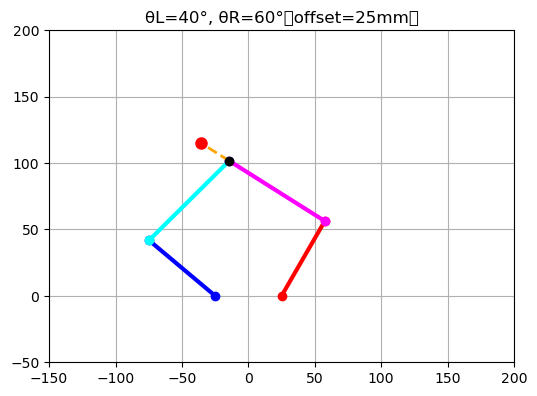

None


In [ ]:
#関数
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
#  FK-1 : 第一リンク（l1）先端座標を求める
# ============================================================
def compute_first_link(theta_l_deg, theta_r_deg, l1=65.0, d=50.0, theta_min=10.0):
    tl = np.radians(theta_l_deg)
    tr = np.radians(theta_r_deg)

    M_L = np.array([-d/2, 0.0])
    M_R = np.array([ d/2, 0.0])

    L_tip = np.array([
        M_L[0] - l1 * np.cos(tl),
        M_L[1] + l1 * np.sin(tl)
    ])

    R_tip = np.array([
        M_R[0] + l1 * np.cos(tr),
        M_R[1] + l1 * np.sin(tr)
    ])

    return L_tip, R_tip


# ============================================================
#  FK-2 : 第二リンクの交点（基準点 P）
# ============================================================
def compute_pen_position(L_tip, R_tip, l2):
    x1, y1 = L_tip
    x2, y2 = R_tip
    d = np.hypot(x2 - x1, y2 - y1)

    if d > 2*l2:
        return None

    a = d/2
    h = np.sqrt(l2**2 - a*a)

    xm = x1 + (x2-x1)*a/d
    ym = y1 + (y2-y1)*a/d

    rx = -(y2 - y1) * (h/d)
    ry =  (x2 - x1) * (h/d)

    p1 = np.array([xm + rx, ym + ry])
    p2 = np.array([xm - rx, ym - ry])

    return p1 if p1[1] >= p2[1] else p2


# ============================================================
#  FK-3 ：ペン先（25mm延長した実ペン先）
# ============================================================
def forward_pen_tip(theta_l_deg, theta_r_deg, l1=65.0, l2=85, d=50.0, offset=25.0):
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)
    P = compute_pen_position(L_tip, R_tip, l2)
    if P is None:
        return None

    dir_vec = P - R_tip
    norm = np.hypot(dir_vec[0], dir_vec[1])
    if norm < 1e-6:
        return None

    unit_vec = dir_vec / norm
    P_tip = P + unit_vec * offset
    return P_tip


# ============================================================
#  IK 初期値：第二リンク交点を目標として解く（通常の5bar IK）
# ============================================================
def ik_candidates(Px, Py, l1=65.0, l2=85.0, d=50.0):
    cands = []

    # 左側
    XL = Px + d/2
    YL = Py
    rL = np.hypot(XL, YL)
    cos_L = (l1*l1 + rL*rL - l2*l2) / (2*l1*rL)
    if abs(cos_L) > 1:
        return []
    baseL = np.arctan2(YL, XL)
    phiL = np.arccos(cos_L)
    left = [baseL + phiL, baseL - phiL]

    # 右側
    XR = Px - d/2
    YR = Py
    rR = np.hypot(XR, YR)
    cos_R = (l1*l1 + rR*rR - l2*l2) / (2*l1*rR)
    if abs(cos_R) > 1:
        return []
    baseR = np.arctan2(YR, XR)
    phiR = np.arccos(cos_R)
    right = [baseR + phiR, baseR - phiR]

    # 4組
    for tL in left:
        for tR in right:
            cands.append((np.degrees(tL), np.degrees(tR)))

    return cands


def plot_full_arm(theta_l_deg, theta_r_deg, l1=65, l2=85, d=50, offset=25, plot=True):
    """
    角度制限・干渉チェックを完全削除したバージョン。
    θL, θR が 0〜360° のどこでも順運動を返せる。
    """

    # --- 第一リンク先端 ---
    L_tip, R_tip = compute_first_link(theta_l_deg, theta_r_deg, l1=l1, d=d)

    # 計算不可 → None
    if L_tip is None or R_tip is None:
        return None

    # --- 第二リンク交点 P ---
    P = compute_pen_position(L_tip, R_tip, l2)
    if P is None:
        return None

    # --- 実ペン先（延長） ---
    dir_vec = P - R_tip
    norm = np.hypot(dir_vec[0], dir_vec[1])

    if norm < 1e-8:
        # 方向が決まらない＝第二リンクが真上などの特異点
        return None

    unit_vec = dir_vec / norm
    P_tip = P + unit_vec * offset

    # --- 描画（オプション） ---
    if plot:
        plt.figure(figsize=(6, 6))
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xlim(-150, 200)
        ax.set_ylim(-50, 200)
        ax.grid(True)

        M_L = np.array([-d/2, 0.0])
        M_R = np.array([ d/2, 0.0])

        ax.plot([M_L[0], L_tip[0]], [M_L[1], L_tip[1]], "o-", lw=3, color="blue")
        ax.plot([M_R[0], R_tip[0]], [M_R[1], R_tip[1]], "o-", lw=3, color="red")

        ax.plot([L_tip[0], P[0]], [L_tip[1], P[1]], "o-", lw=3, color="cyan")
        ax.plot([R_tip[0], P[0]], [R_tip[1], P[1]], "o-", lw=3, color="magenta")

        ax.plot([P[0], P_tip[0]], [P[1], P_tip[1]], "--", lw=2, color="orange")

        ax.plot(P[0], P[1], "ko", markersize=6)
        ax.plot(P_tip[0], P_tip[1], "ro", markersize=8)

        plt.title(f"θL={theta_l_deg}°, θR={theta_r_deg}°（offset={offset}mm）")
        plt.show()

    # --- 順運動の結果を返す ---    
    return P_tip, P, L_tip, R_tip



print(plot_full_arm(40,60, l1=65, l2=85, d=50, offset=25, plot=True))

In [27]:
import csv
import numpy as np

# 角度リストの生成（-180 ～ 180 を 1.8° 刻み）
ANGLES = np.arange(-180, 180 + 1e-6, 1.8)

def generate_angle_csv(outpath="angles_to_xy.csv"):
    """
    plot_full_arm() を使って逆引きテーブル用の CSV を生成する
    """
    rows = []
    total = 0
    ok = 0

    for thL in ANGLES:
        for thR in ANGLES:

            total += 1

            # あなたの関数を呼び出し
            result = plot_full_arm(
                thL, thR,
                l1=65, l2=85, d=50, offset=25,
                plot=False
            )

            # 無効な場合
            if result is None:
                continue

            # 有効 → 座標を取り出して追加
            x, y = result
            rows.append([thL, thR, x, y])
            ok += 1

    print(f"試行回数 total={total}, 有効データ ok={ok}")

    # CSV に書き込み
    with open(outpath, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["theta_L", "theta_R", "x", "y"])
        writer.writerows(rows)

    print(f"CSV 出力完了 → {outpath}")


# =============================
# 実行
# =============================
generate_angle_csv("angles_to_xy.csv")


試行回数 total=40401, 有効データ ok=0
CSV 出力完了 → angles_to_xy.csv


In [18]:
import numpy as np
import pickle
from scipy.spatial import cKDTree

# CSV を読み込んだ直後に以下を実行して KD-tree を作る
def generate_kdtree_from_csv(csv_path="rad2xy.csv", out_pkl="lut_tree.pkl"):

    theta_L = []
    theta_R = []
    X = []
    Y = []

    with open(csv_path, "r", encoding="utf-8") as f:
        next(f)  # ヘッダ行をスキップ
        for line in f:
            thL, thR, x, y = line.strip().split(",")
            theta_L.append(float(thL))
            theta_R.append(float(thR))
            X.append(float(x))
            Y.append(float(y))

    theta_L = np.array(theta_L)
    theta_R = np.array(theta_R)
    X = np.array(X)
    Y = np.array(Y)

    # KD-tree 生成
    xy = np.column_stack([X, Y])
    tree = cKDTree(xy)

    # pkl 保存
    with open(out_pkl, "wb") as f:
        pickle.dump((tree, theta_L, theta_R), f)

    print("KD-tree を保存しました →", out_pkl)


# 実行
generate_kdtree_from_csv("rad2xy.csv", "lut_tree.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'rad2xy.csv'

In [19]:
import csv
from pathlib import Path

import numpy as np
# ✅ あなたの順運動学関数をインポート
# from your_module import plot_full_arm

# === パラメータ ===
L1 = 65
L2 = 85
D  = 50
OFFSET = 25

STEP = 1.8   # ステッピングモーター刻み
ANGLES = np.arange(0, 360, STEP)

BASE_DIR = Path(__file__).resolve().parent  # この .py があるディレクトリ


def generate_lookup_csv(outpath=None):

    if outpath is None:
        outpath = BASE_DIR / "lut_angles_to_xy.csv"
    else:
        outpath = Path(outpath)

    rows = []
    total = 0
    ok = 0

    for thL in ANGLES:
        for thR in ANGLES:

            total += 1

            # --- ★ 順運動（plot_full_arm）を使う ---
            result = plot_full_arm(
                thL, thR,
                l1=L1, l2=L2, d=D, offset=OFFSET,
                plot=False  # 描画しない
            )

            # 返り値は (P_tip, P, L_tip, R_tip) または None
            if result is None:
                continue

            P_tip, P, L_tip, R_tip = result

            if P_tip is None:
                continue

            x, y = float(P_tip[0]), float(P_tip[1])
            rows.append([thL, thR, x, y])
            ok += 1

        print(f"θL={thL:.1f}° まで完了…  valid={ok}/{total}")

    # ---- CSV 書き込み ----
    print(f"\nCSV に書き出し中… 行数={len(rows)}")
    outpath = outpath.with_suffix(".csv")
    with outpath.open("w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["theta_L", "theta_R", "x", "y"])
        writer.writerows(rows)

    print("\n===== 完了 =====")
    print(f"総組み合わせ : {total}")
    print(f"有効姿勢数    : {ok}")
    print(f"保存先        : {outpath.resolve()}")


if __name__ == "__main__":
    generate_lookup_csv()


NameError: name '__file__' is not defined